In [1]:
import numpy as np
import dapy.filters as filters
from dapy.models.lorenz_1963 import Lorenz1963Model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 100

## Model

Three-dimensional dynamical system due to Lorenz [1] with flow map $\varphi : \mathbb{R}_{\geq 0} \to (\mathbb{R}^3 \to \mathbb{R}^3)$ defined such that $\boldsymbol{x}(\tau) = \varphi(\tau)(\boldsymbol{x}_0)$ where $\boldsymbol{x}(\tau), \tau > 0$ is the solution to the initial value problem
\begin{align}
  \frac{\mathrm{d} x_0}{\mathrm{d} \tau} &= \sigma (x_1 - x_0), \\
  \frac{\mathrm{d} x_1}{\mathrm{d} \tau} &= x_0 (\rho - x_2) - x_1, \\
  \frac{\mathrm{d} x_2}{\mathrm{d} \tau} &= x_0 x_1 - \beta x_2, \\
  \text{and } \boldsymbol{x}(0) &= \boldsymbol{x}_0.
\end{align}

Here we use the (standard) parameter values $\rho = 28, \sigma=10, \beta=\frac{8}{3}$ which exhibit chaotic dynamics. An implicit mid-point method is used to define an approximate flow map $\tilde{\varphi}(\Delta) \approx \varphi(\Delta)$ with time step $\Delta = 0.005$ and $S=10$ time steps per state update. The state update is $\boldsymbol{x}_t = \bigcirc_{s=1}^S \big(\tilde{\varphi}({\Delta})\big)(\boldsymbol{x}_{t-1}) + \boldsymbol{\xi}_t$ with additive noise with distribution $\boldsymbol{\xi}_t \sim \mathcal{N}(\mathbf{0}_3, 0.1^2 \mathbb{I}_3)$ and initial state distribution $\boldsymbol{x}_0 \sim \mathcal{N}(\mathbf{1}_3, 0.5^2 \mathbb{I}_3)$. The first $x_{0,t}$ component of the state is noisily observed $y_t = x_{0,t} + \epsilon_t$, with additive Gaussian noise $\epsilon_t \sim \mathcal{N}(0, 5^2)$.

### References

1. Lorenz, Edward Norton (1963). Deterministic nonperiodic flow. Journal of the Atmospheric Sciences. 20 (2): 130–141.

In [2]:
model_params = {
    'sigma': 10.,
    'rho': 28.,
    'beta': 8. / 3.,
    'initial_state_mean': 1.,
    'initial_state_std': 0.5,
    'state_noise_std': 0.1,
    'observation_function':  lambda x, t: x[..., 0:1],
    'observation_noise_std': 5.,
    'time_step': 0.005,
    'num_integrator_step_per_update': 5,
}
model = Lorenz1963Model(**model_params)

## Generate data from model

In [3]:
num_observation_time = 800
observation_time_indices = np.arange(num_observation_time)
seed = 20171027
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices)

Sampling: 100%|██████████|800/800 [00:00<00:00, 21915.58time-steps/s]

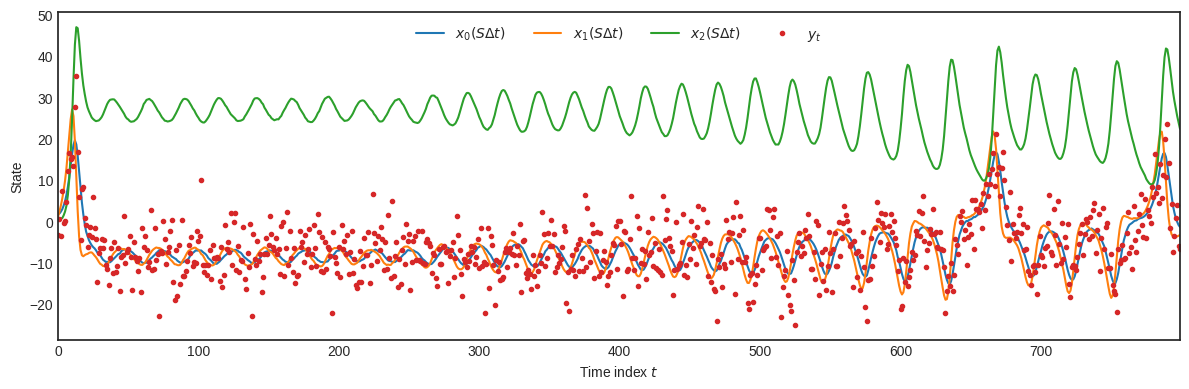

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(observation_time_indices, state_sequence)
ax.plot(observation_time_indices, observation_sequence, '.')
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State')
_ = ax.set_xlim(0, num_observation_time - 1)
ax.legend(['$x_0(S\Delta t)$', '$x_1(S\Delta t)$', '$x_2(S\Delta t)$', '$y_t$'], ncol=4)
fig.tight_layout()

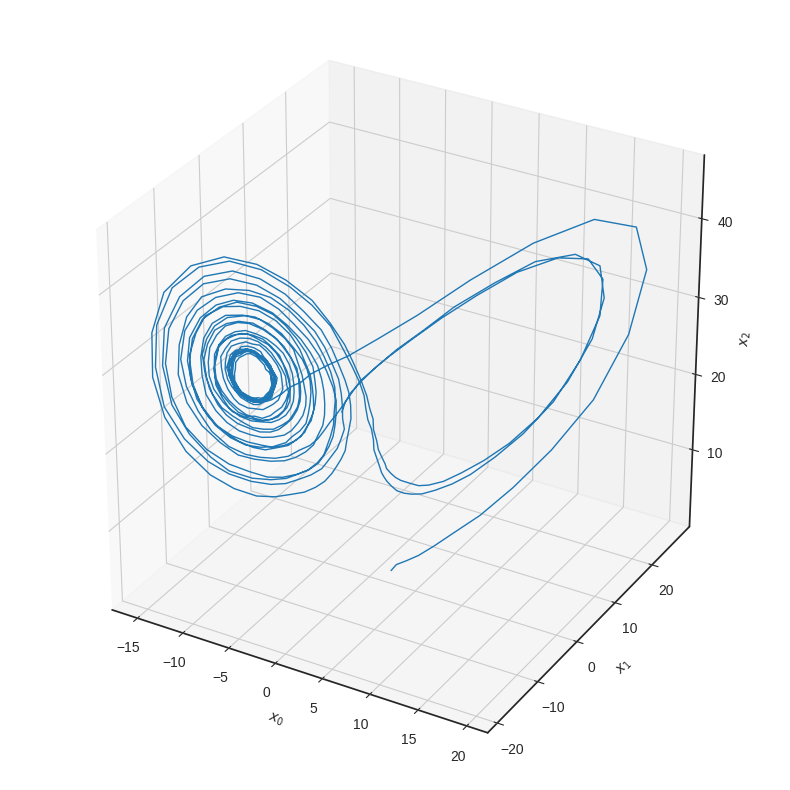

In [5]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.plot(*state_sequence.T, '-', lw=1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
fig.tight_layout()

## Infer state from observations

In [6]:
def plot_results(results, observation_time_indices, state_sequence=None, 
                 plot_particles=False, plot_region=True, 
                 particle_skip=2, trace_alpha=0.5):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 9))
    for i, ax in zip(range(3), axes):
        ax.plot(results['state_mean_sequence'][:, i], 'g-', lw=1, label='Est. mean')
        if plot_region:
            ax.fill_between(
                observation_time_indices,
                results['state_mean_sequence'][:, i] - 3 * results['state_std_sequence'][:, i],
                results['state_mean_sequence'][:, i] + 3 * results['state_std_sequence'][:, i],
                alpha=0.25, color='g', label='Est. mean ± 3 standard deviation'
            )
        if plot_particles:
            lines = ax.plot(
                observation_time_indices, results['state_particles_sequence'][:, ::particle_skip, i], 
                'r-', lw=0.25, alpha=trace_alpha)
            lines[0].set_label('Particles')
        if state_sequence is not None:
            ax.plot(observation_time_indices, state_sequence[:, i], 'k--', label='Truth')
        ax.set_ylabel('$x_{0}$'.format(i))
        ax.legend(loc='upper center', ncol=4)
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

### Ensemble Kalman filter (perturbed observations)

In [7]:
enkf = filters.EnsembleKalmanFilter()

In [8]:
results_enkf = enkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|800/800 [00:00<00:00, 2490.28time-steps/s]

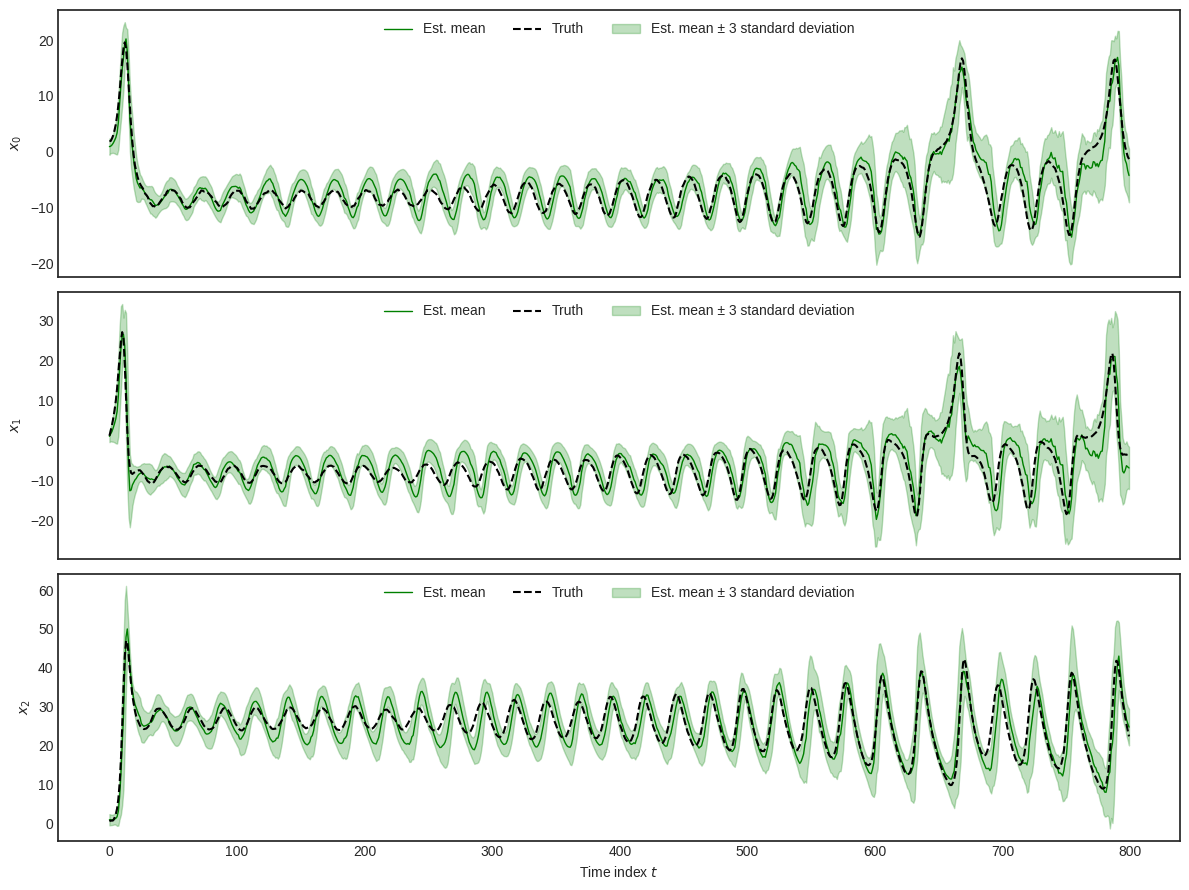

In [9]:
fig, axes = plot_results(results_enkf, observation_time_indices, state_sequence)

### Ensemble Trasform Kalman filter (deterministic square root)

In [10]:
etkf = filters.EnsembleTransformKalmanFilter()

In [11]:
results_etkf = etkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|800/800 [00:00<00:00, 1991.57time-steps/s]

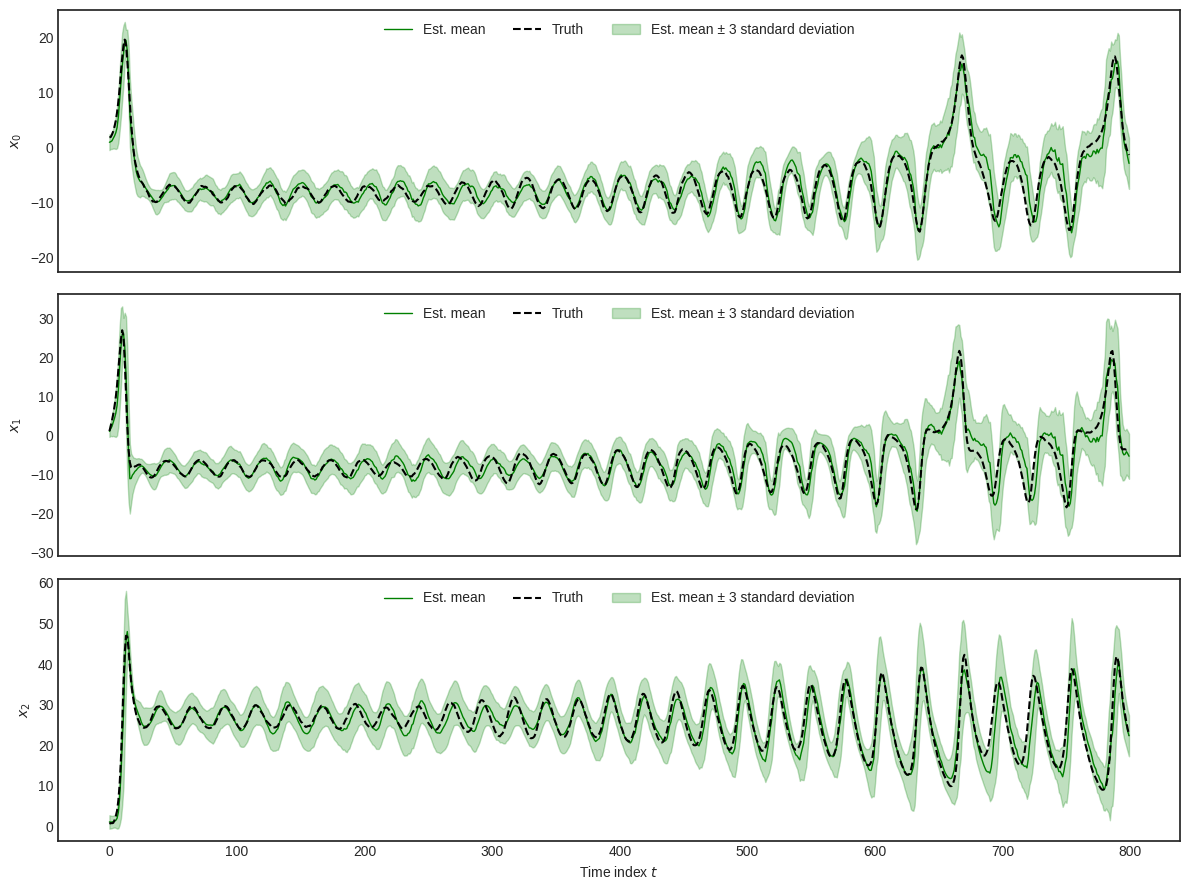

In [12]:
fig, axes = plot_results(results_etkf, observation_time_indices, state_sequence)

### Bootstrap particle filter

In [13]:
bspf = filters.BootstrapParticleFilter()

In [14]:
results_bspf = bspf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|800/800 [00:00<00:00, 2743.01time-steps/s]

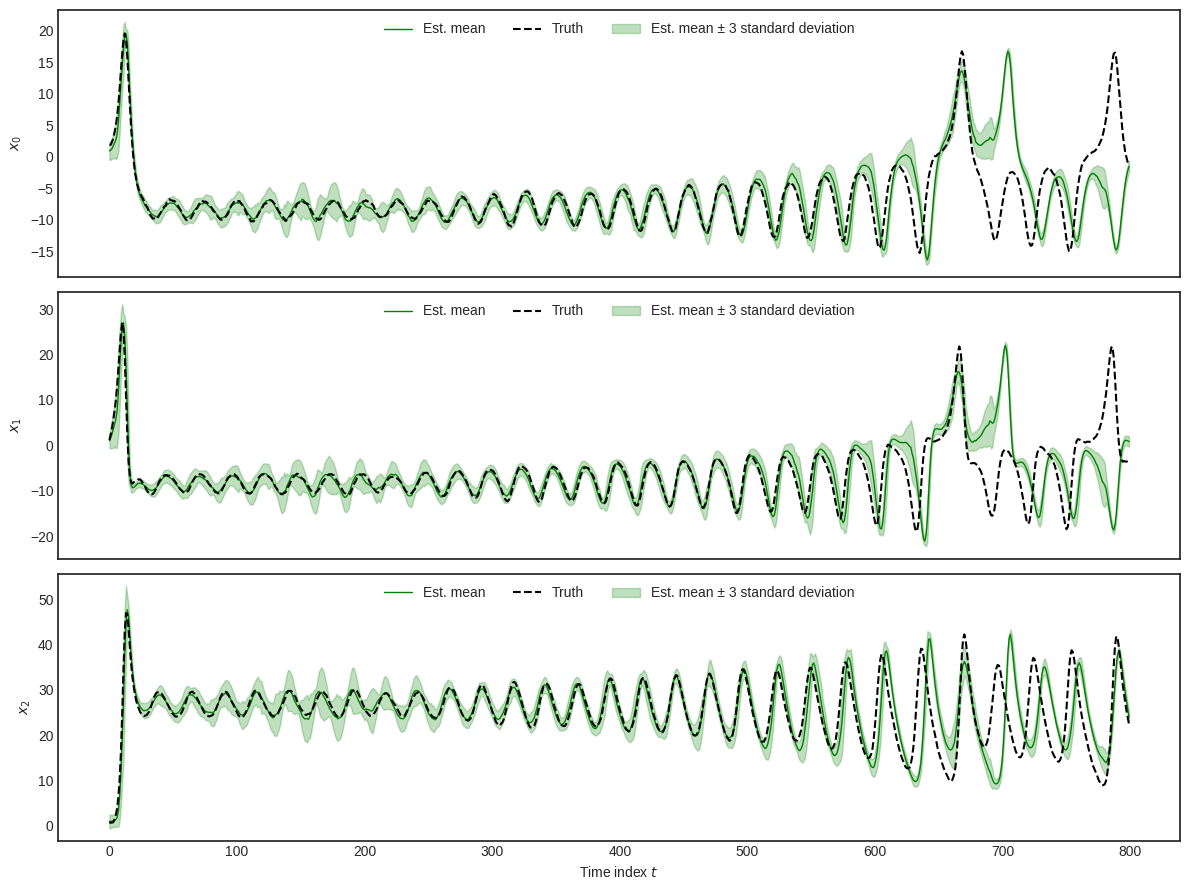

In [15]:
fig, axes = plot_results(results_bspf, observation_time_indices, state_sequence)

### Ensemble transform particle filter

In [16]:
etpf = filters.EnsembleTransformParticleFilter()

In [17]:
results_etpf = etpf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=100, rng=rng, return_particles=True)

Filtering: 100%|██████████|800/800 [00:01<00:00, 560.09time-steps/s]

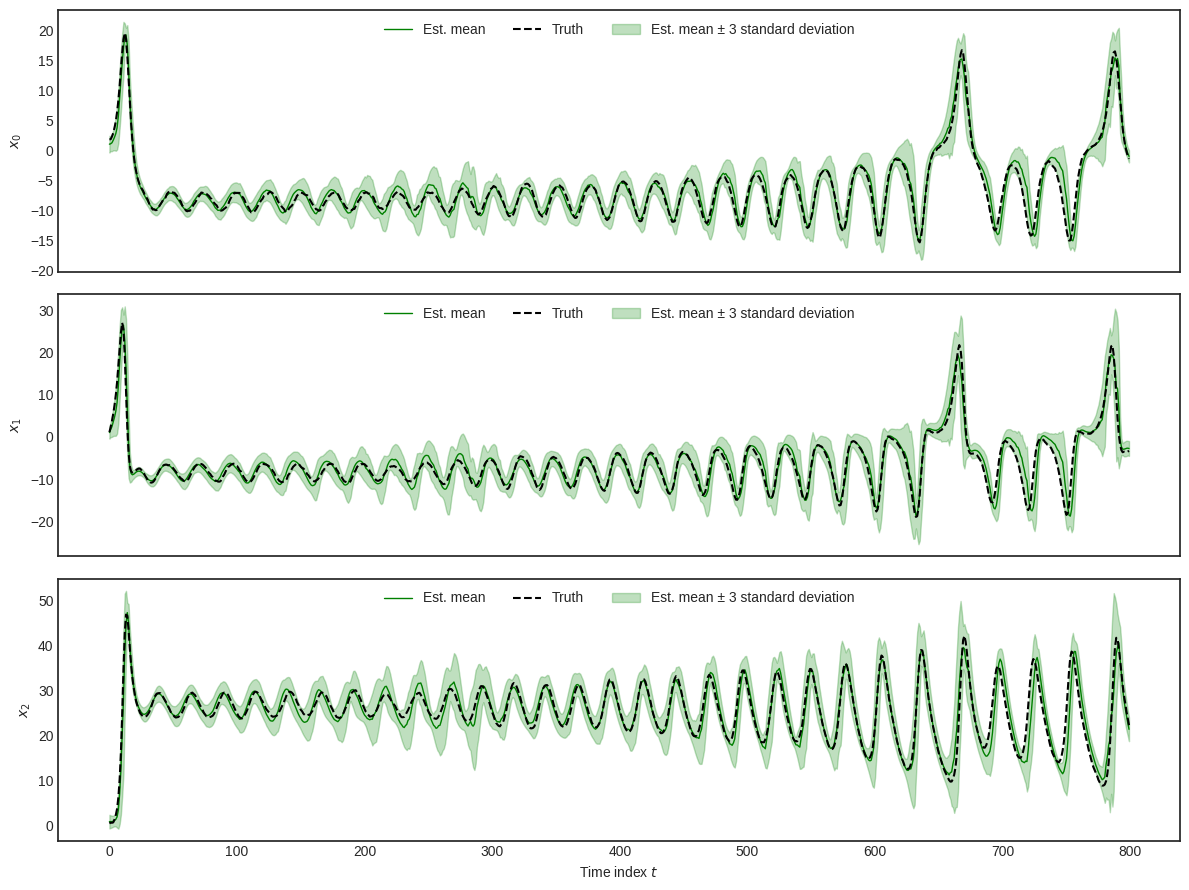

In [18]:
fig, axes = plot_results(results_etpf, observation_time_indices, state_sequence)